<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/old%20models/full_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.transforms.functional as F

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [5]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166436, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 166436 (delta 11), reused 5 (delta 4), pack-reused 166415
Receiving objects: 100% (166436/166436), 800.50 MiB | 57.21 MiB/s, done.
Resolving deltas: 100% (36970/36970), done.
Updating files: 100% (249473/249473), done.


'/content'

In [6]:
!pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)



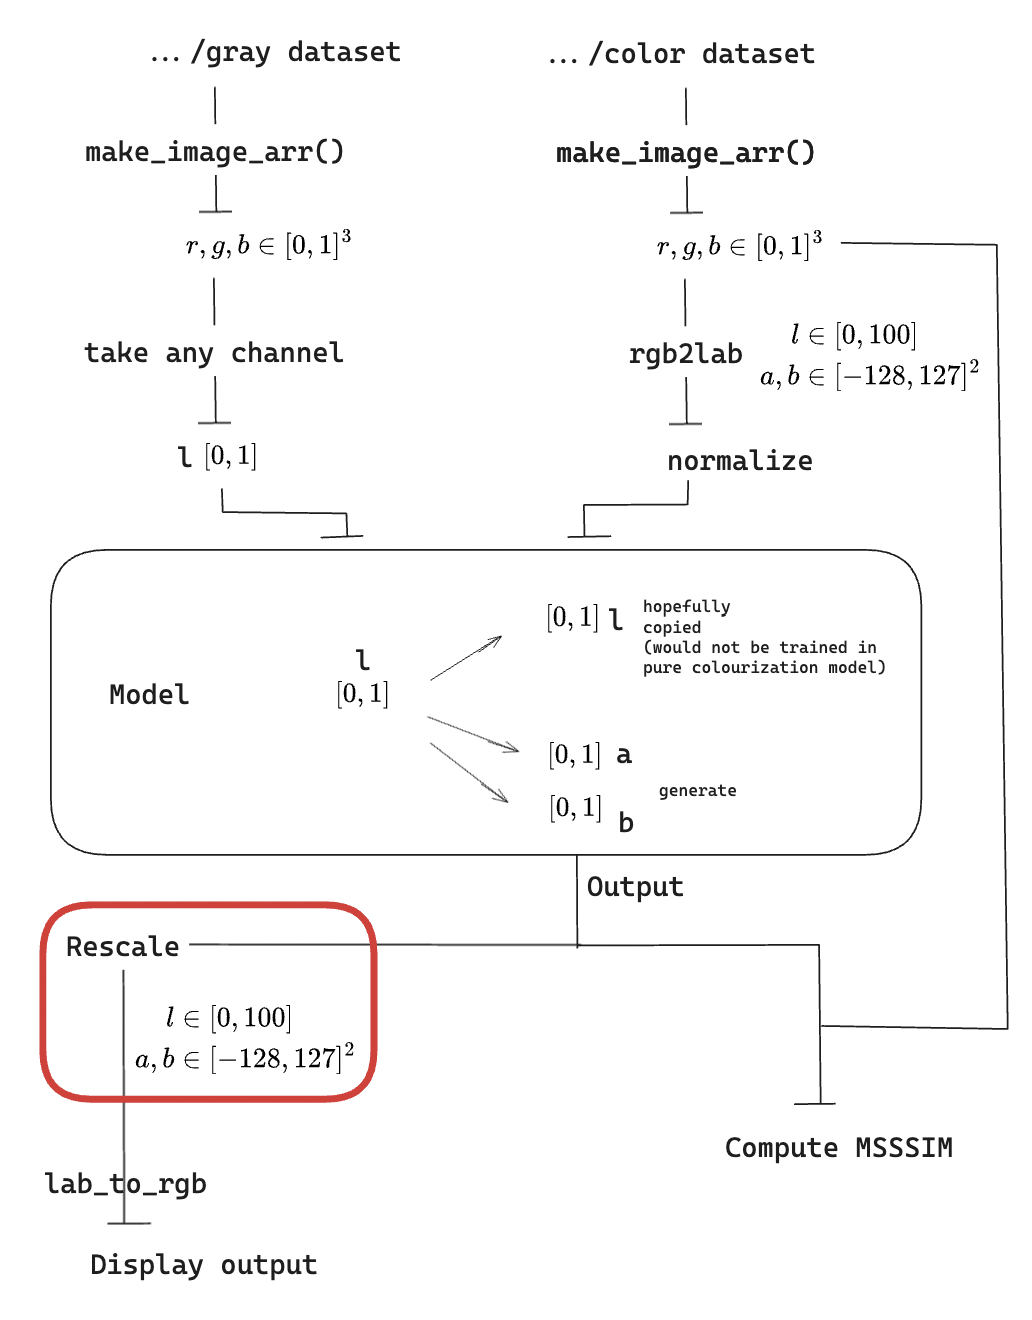

In [7]:
!pip install -q kornia


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.1 MB/s eta 0:00:00


In [8]:
import kornia
import skimage

In [9]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path,cut=None,end=False):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  if cut is not None:
    files = files[:cut]
  if end:
    files = files[-1:]

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


### Making `color`

Fun fact: LAB colour space covers more than the visual spectrum so it is larger than RGB space!

See:
```python
lmin, lmax, amin, amax, bmin, bmax = 0,0,0,0,0,0
for r in np.linspace(0,1):
  for g in np.linspace(0,1):
    for b in np.linspace(0,1):
      lab = skimage.color.rgb2lab([[r,g,b]])
      lmin = min(lmin, lab[0][0])
      lmax = max(lmax, lab[0][0])
      amin = min(amin, lab[0][1])
      amax = max(amax, lab[0][1])
      bmin = min(bmin, lab[0][2])
      bmax = max(bmax, lab[0][2])

print(lmin, lmax, amin, amax, bmin, bmax)
>>> 0 100.0 -86.18302974439501 98.23305386311321 -107.85730020669489 94.47812227647823
```


In [10]:
rgb_np = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/color',cut=9600)

100%|██████████| 9600/9600 [00:11<00:00, 827.63it/s]


In [11]:
lab_np = skimage.color.rgb2lab(rgb_np)


## Trying to get away without squish

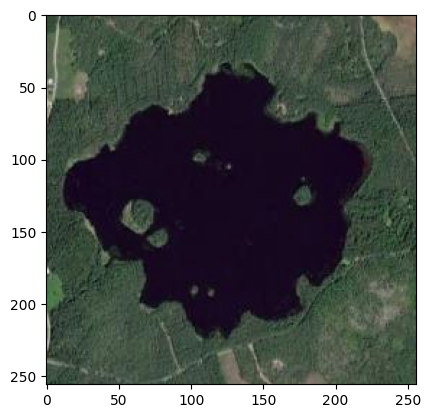

In [12]:
plt.imshow(skimage.color.lab2rgb(lab_np[0]))

In [13]:
color = torch.from_numpy(np.moveaxis(lab_np, [3,1], [1,2])).to(device)

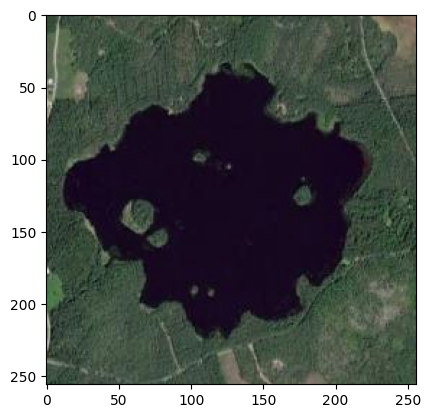

In [14]:
lab_pil = np.moveaxis(color[0].cpu().detach().numpy(), [1,2], [0,1])
plt.imshow(skimage.color.lab2rgb(lab_pil))

In [15]:
# before pushing to GPU, empty RAM
# torch.cuda.empty_cache()

In [16]:
# free System RAM
del lab_np, rgb_np

In [17]:
color.shape

torch.Size([9600, 3, 256, 256])

### Making `gray`

In [18]:
graynp = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/gray',cut=9600)
graynp.shape

100%|██████████| 9600/9600 [00:10<00:00, 902.22it/s]


(9600, 256, 256, 3)

In [19]:
# take one axis
graynp = np.moveaxis(graynp, [3,1], [1,2])

# convert to LAB scale
graynp = graynp[:, 0:1, :, :] * 100



In [20]:
graynp.shape

(9600, 1, 256, 256)

In [21]:

# tensor to GPU
gray = torch.from_numpy(graynp).to(device)
gray.shape

torch.Size([9600, 1, 256, 256])

### All done

3031
torch.Size([3, 256, 256])
(256, 256, 3)


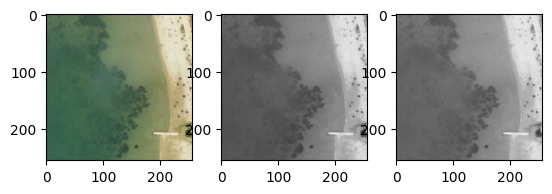

9070
torch.Size([3, 256, 256])
(256, 256, 3)


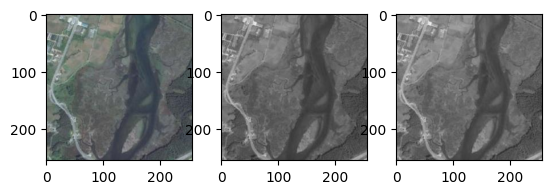

2979
torch.Size([3, 256, 256])
(256, 256, 3)


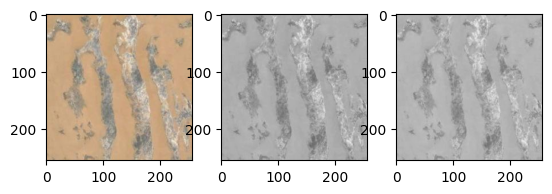

In [22]:
for i in np.random.randint(9600,size=3):
  print(i)
  plt.subplot(1,3,1)
  print(color[i].shape)
  # lab_pil = np.moveaxis(unsquish_lab(color[i].cpu().detach()), 0,-1)
  lab_pil = np.moveaxis(color[i].cpu().detach().numpy(), [1,2], [0,1])
  print(lab_pil.shape)
  plt.imshow(skimage.color.lab2rgb(lab_pil))
  plt.subplot(1,3,2)
  plt.imshow(F.to_pil_image(gray[i].repeat(3,1,1) / 100))
  plt.subplot(1,3,3)
  plt.imshow(F.to_pil_image(color[i][0].repeat(3,1,1) / 100))
  plt.show()

# 3. Model
Model generated below:

In [23]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            # nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            # nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            # nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            # nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            # nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            # nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            # nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            # nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 2
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in tqdm(range(num_iterations)):
      running_loss = 0.0
      batch_indexes = torch.randint(high=9600, size=(batch_size,1))

      inputs = gray[batch_indexes].squeeze(1)
      targets = color[batch_indexes].squeeze(1)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


[1] loss: 0.98711


100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]

[2] loss: 1.19804
Finished Training


Training set performance

i: 3117
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(18.1720, device='cuda:0', grad_fn=<MseLossBackward0>)


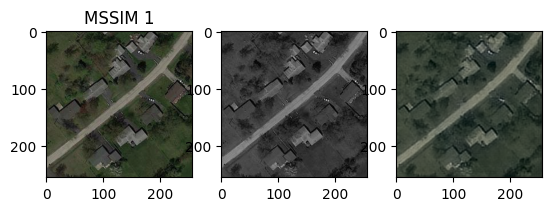

i: 8760
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(76.5184, device='cuda:0', grad_fn=<MseLossBackward0>)


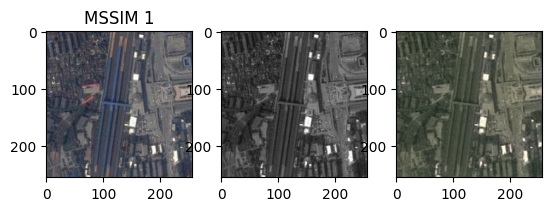

i: 8273
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(70.2395, device='cuda:0', grad_fn=<MseLossBackward0>)


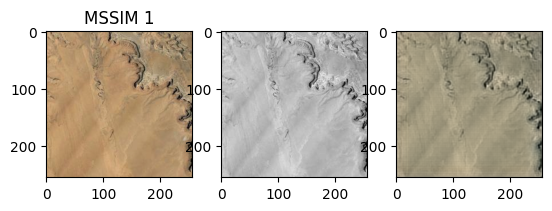

In [27]:
autoencoder.eval()
for i in np.random.randint(9600,size=3):

  # Colorize the image
  t = gray[i].unsqueeze(0)
  output = autoencoder(t)

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(color[i], output))

  plt.subplot(1,3,1)
  plt.imshow(F.to_pil_image(kornia.color.lab_to_rgb(color[i])))
  plt.title(f"MSSIM 1")

  plt.subplot(1,3,2)
  plt.imshow(F.to_pil_image(gray[i]/100),cmap='gray')
  # MSSSIM between original in LAB space and gray (all channels equal to lightness channel)

  # input_mssim = ms_ssim(color[i].unsqueeze(0).to(device), gray[i].repeat(3,1,1).unsqueeze(0).to(device), data_range=1, size_average=True) # return scalar
  # plt.title(f"MSSIM {input_mssim:.2f}")

  plt.subplot(1,3,3)
  plt.imshow(F.to_pil_image(kornia.color.lab_to_rgb((output.squeeze()))))
  # output_mssim = ms_ssim(color[i].unsqueeze(0).to(device), output.to(device), data_range=1, size_average=True) # return scalar
  # plt.title(f"MSSIM {output_mssim:.2f}")

  plt.show()



In [ ]:
l = output.squeeze()[0]

In [ ]:
output.squeeze()[1]

tensor([[-1.2543, -0.9112, -0.4322,  ..., -0.9028, -1.7930, -1.6155],
        [-0.8179, -1.7514, -1.1296,  ..., -1.7089, -2.4429, -2.5012],
        [-0.0242, -0.6861, -0.3437,  ..., -1.3291, -1.6142, -1.7707],
        ...,
        [ 0.9633,  1.7548,  2.4195,  ..., -1.1832, -1.3994, -1.9145],
        [ 0.8308,  1.5604,  0.6637,  ..., -1.5770, -2.2470, -1.6899],
        [ 0.1798, -0.0539, -0.3364,  ..., -2.2667, -2.5440, -1.6890]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# torch.save(autoencoder.decoder,'/content/CPSC-440-Project/models/old models/lab_msssim_decoder')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/old models/lab_mle_encoder_128')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
%cd CPSC-440-Project

/content/CPSC-440-Project


In [ ]:

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!git add .

In [ ]:
!git config pull.rebase false  # merge (the default strategy)

In [ ]:
!git pull -m 'didnt reclone'

error: unknown switch `m'
usage: git pull [<options>] [<repository> [<refspec>...]]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    --recurse-submodules[=<on-demand>]
                          control for recursive fetching of submodules

Options related to merging
    -r, --rebase[=(false|true|merges|interactive)]
                          incorporate changes by rebasing rather than merging
    -n                    do not show a diffstat at the end of the merge
    --stat                show a diffstat at the end of the merge
    --log[=<n>]           add (at most <n>) entries from shortlog to merge commit message
    --signoff[=...]       add a Signed-off-by trailer
    --squash              create a single commit instead of doing a merge
    --commit              perform a commit if the merge succeeds (default)
    --edit                edit message before committing
    --cleanup <mode>      

In [ ]:
!git push

To https://github.com/StuartLiv/CPSC-440-Project
 ! [rejected]            main -> main (non-fast-forward)
error: failed to push some refs to 'https://github.com/StuartLiv/CPSC-440-Project'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!